# 0.0 IMPORTS

In [1]:
import psycopg2
import inflection

import pandas                  as pd
import seaborn                 as sns
import numpy                   as np
import scikitplot              as skplt
import matplotlib.pyplot       as plt
import boruta                  as bt
import xgboost                 as xgb
import random                  as rd
import pickle
import os

from sklearn.model_selection   import train_test_split, StratifiedKFold
from lightgbm                  import LGBMClassifier
from sklearn.naive_bayes       import GaussianNB
from psycopg2                  import Error
from sklearn.ensemble          import ExtraTreesClassifier, RandomForestRegressor
from tabulate                  import tabulate
from sklearn.preprocessing     import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.preprocessing     import StandardScaler
from sklearn.model_selection   import train_test_split
from IPython.display           import Image
from IPython.core.display      import HTML
from boruta                    import BorutaPy
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import StratifiedShuffleSplit as sss

from sklearn                   import metrics            as m
from sklearn                   import neighbors          as nh
from sklearn                   import ensemble           as en
from sklearn                   import model_selection    as ms
from scipy                     import stats              as ss

##  Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


# precision_at_k
def precision_at_k_(data, k):
    data = data.reset_index(drop=True)
    data['n_samples'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['n_samples']
    return data.loc[k, 'precision_at_k']

# recall_at_k
def recall_at_k_(data, k):
    data = data.reset_index(drop=True)
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    return data.loc[k, 'recall_at_k']


def model_results (model_ml, model_name, df, k ):
    
    precision_list = []
    recall_list = []
    
    #prediction
    yhat_proba_model = model_ml.predict_proba(x_validation)

    # copy dataframe
    df = x_validation.copy()
    df['response'] = y_validation.copy()

    # propensity score
    df['score'] = yhat_proba_model[:, 1].tolist()

    # sort clients by propensity score
    df = df.sort_values( 'score', ascending=False )

    # compute precision at k 
    precision_model = precision_at_k_( df, k )
    
    # compute recall at k
    recall_model = recall_at_k_( df, k )
    
    precision_list.append(precision_model)
    recall_list.append(recall_model)

    # plot
    fig, axs = plt.subplots(ncols= 2, figsize = (12,6));
    skplt.metrics.plot_cumulative_gain(Y_vali, yhat_proba_model, ax=axs[0],title='Cumulative Gain Curve');
    skplt.metrics.plot_lift_curve(Y_vali, yhat_proba_model,ax=axs[1],title='Lift Curve');
    
    # dataframe
    model_rank = pd.DataFrame(columns = {'Model':[], "Precision_at_k": [], "Recall_at_k": []})
    
    new_row = {'Model': model_name, 
               'Precision_at_k': precision_model,
               'Recall_at_k': recall_model}
            
    model_rank = model_rank.append(new_row, ignore_index = True)
    return model_rank

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()
####-------------------------------------------------------------------------------------------------------------------------------------------------------



def precision_at_k(data, x_val, y_val, yhat_model, k):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    
    # propensity score
    data['score'] = yhat_model[:, 1].tolist()      
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k(data, x_val, y_val, yhat_model, k):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    
    # propensity score
    data['score'] = yhat_model[:, 1].tolist()  
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


def cross_validation(data, models_performance, num_folds, model_name, model, x_train, y_train, k):
    
    kfold = ms.StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)
    
    precision_list = []
    recall_list = []
    
    
    i=1
    for train_cv,val_cv in kfold.split(x_train, y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict_proba(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        
        precision = round(precision_at_k(data, x_val_fold, y_val_fold, yhat_model, k), 3)
        precision_list.append(precision)
        
        recall = round(recall_at_k(data, x_val_fold, y_val_fold, yhat_model, k), 3)
        recall_list.append(recall)
        
        
        
                
        i+=1
    
    precision_str = np.round(np.mean(precision_list), 3).astype(str) + ' +/- ' + np.round(np.std(precision_list), 3).astype(str)
    recall_str    = np.round(np.mean(recall_list), 3).astype(str)    + ' +/- ' + np.round(np.std(recall_list), 3)   .astype(str)
    models_performance = pd.DataFrame(columns = {'Model':[], "Precision_at_k": [], "Recall_at_k": []})
        
    models_performance = models_performance.append(pd.Series([model_name, precision_str, recall_str], index = models_performance.columns), ignore_index = True)

    return models_performance



Populating the interactive namespace from numpy and matplotlib


##  Get Data from Database

In [3]:
#HOST = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
#PORT = '5432'
#DATABASE = 'comunidadedsdb'
#USER = 'member'
#PASSWORD ='cdspa'

# # Connect to an existing database
# connection = psycopg2.connect(user="member",
#                               password="cdspa",
#                               host="comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com",
#                               port="5432",
#                               database="comunidadedsdb")
# # create a cursor
# cursor = connection.cursor()
# query = """
#             SELECT *
#                FROM pa004.users pu 
#                INNER JOIN pa004.vehicle pv 	 ON pv.id = pu.id 
#                INNER JOIN pa004.insurance pi ON pi.id = pu.id
#                ORDER BY pu.id """

# cursor.execute(query)
# print("Selecting rows from pa004 table using cursor.fetchall ended")
# pa_records = cursor.fetchall()

# df = pd.read_sql(query,connection)  
    
# # close the connection
# connection.close()
# df = df.drop (df.columns[[5,9]], axis = 1)
# df.head()


#df.to_csv('C:/Users/Djalma.junior/DS/PA4/dataset/train.csv', index = False)

##  Load dataset

In [4]:
df_raw = pd.read_csv ('C:/Users/Djalma.junior/DS/PA4/dataset/train.csv')

#  1.0 DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

## 1.2. Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.3. Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5. Descriptive Statistics

In [10]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

### 1.5.1. Numerical Atributes

In [11]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,381108.0,381108.0,190554.000000,190554.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 FEATURE ENGINEERING

In [12]:
df2 = df1.copy()

## 2.1 Hypothesis Mental Map

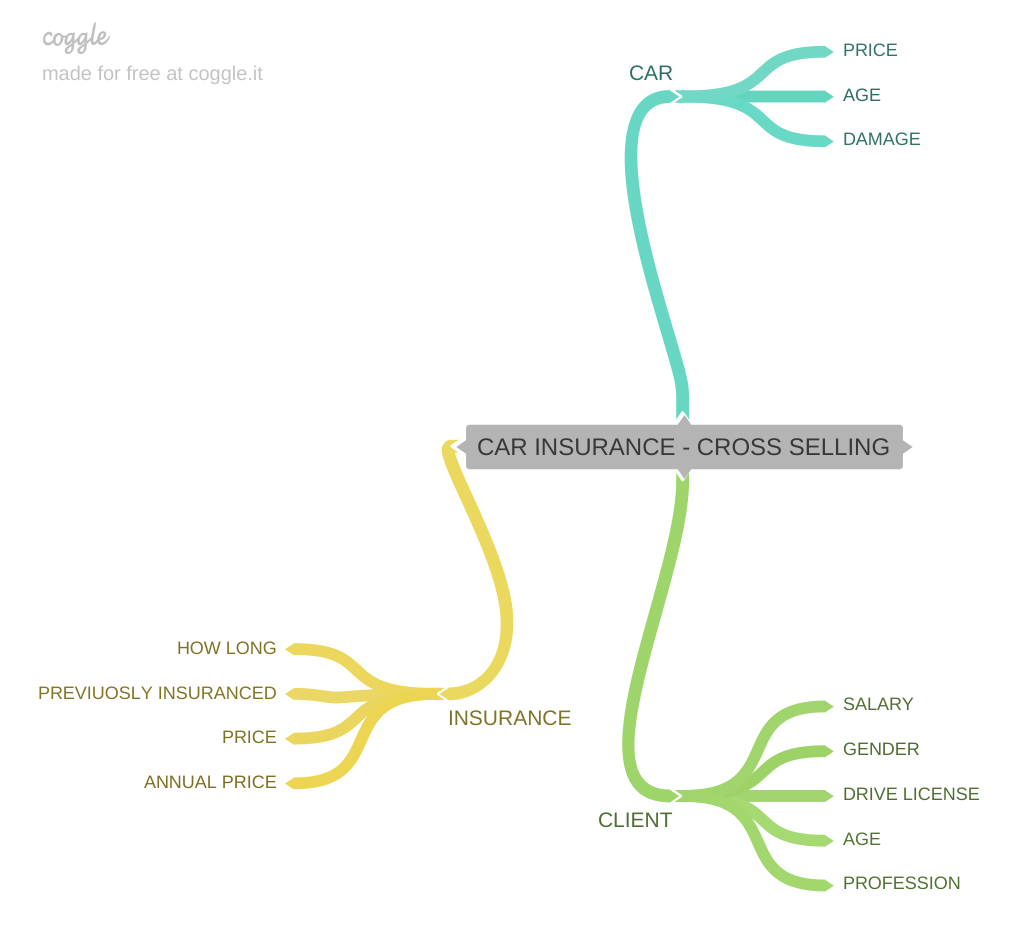

In [13]:
Image ('IMG/CAR_INSURANCE_CROSS_SELLING.png')

###  2.2.1 Customer Hypotheses







1. Mulheres estão mais propensas a contratar seguros de carro.
2. Quanto maior a idade, maior a possibilidade de contratar um seguro de carro.
3. O local de residência influi na decisão de contratar um seguro de carro.
4. Pessoas casadas possuem maior tendência de contratar um seguro de carro.
5. Pessoas com filhos possuem maior tendência de contratar um seguro de carro.




### 2.2.2 Vehicle Hypotheses

1. Pessoas que já tiveram danos em seus carros tem maior propensão a contratar um seguro de carro.
2. Pessoas que a já possuem seguro de carro tem maior propensão a adquirir uma nova apólice.
3. Pessoas com veículos mais novos tem maior tendência a contratar seguro de carro.
4. Pessoas que utilizam o carro de maneira mais frequente tem maior tendência a contratar um seguro de carro.

### 2.2.3 Insurance Company Hypotheses

1. Clientes com relação mais antiga com a seguradora tem maior propensão em contratar um novo produto.
2. Clientes com gastos mais elevados em seguros de saúde tem maior tendência em contratar um novo produto.
3. O canal de comunicação utilizado para realizar a oferta influí na aceitação do novo produto.  

###  2.3 Hypotheses Final List

1. Mulheres estão mais propensas a contratar seguros de carro.
2. Quanto maior a idade, maior a possibilidade de contratar um seguro de carro.
3. O local de residência influi na decisão de contratar um seguro de carro.
4. Pessoas que já tiveram danos em seus carros tem maior propensão a contratar um seguro de carro.
5. Pessoas que a já possuem seguro de carro tem maior propensão a adquirir uma nova apólice.
6. Pessoas com veículos mais novos tem maior tendência a contratar seguro de carro.
7. Clientes com relação mais antiga com a seguradora tem maior propensão em contratar um novo produto.

## 2.2. Feature Engineering


In [14]:
df2 ['vehicle_damage'] = df2['vehicle_damage'].apply (lambda x : 1 if x == 'Yes' else 0 ).astype(int64)

In [15]:
df2 ['vehicle_age'] = df2 ['vehicle_age'].apply (lambda x: 'less_1_year'   if x == '< 1 Year'  else  'btw_1_2_years'    if x == '1-2 Year'    else 'over_2_years') 


#  3.0 FILTRAGEM DE VARIÁVEIS



In [16]:
df3 = df2.copy()